In [38]:
import pandas as pd
import json
import requests
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import numpy as np
import asyncio
from dash import Dash, html, dash_table, dcc
import datetime
import time
from scipy.optimize import minimize 
import os
import random

In [39]:
nasdaq = pd.read_html('Quotes For Nasdaq-100 Index _ Nasdaq.html')[0].Symbol.values


In [40]:
nasdaq

array(['AAPL', 'ABNB', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'AMAT', 'AMD',
       'AMGN', 'AMZN', 'ANSS', 'ASML', 'AVGO', 'AZN', 'BIIB', 'BKNG',
       'BKR', 'CCEP', 'CDNS', 'CDW', 'CEG', 'CHTR', 'CMCSA', 'COST',
       'CPRT', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTSH', 'DASH',
       'DDOG', 'DLTR', 'DXCM', 'EA', 'EXC', 'FANG', 'FAST', 'FTNT',
       'GEHC', 'GFS', 'GILD', 'GOOG', 'GOOGL', 'HON', 'IDXX', 'ILMN',
       'INTC', 'INTU', 'ISRG', 'KDP', 'KHC', 'KLAC', 'LIN', 'LRCX',
       'LULU', 'MAR', 'MCHP', 'MDB', 'MDLZ', 'MELI', 'META', 'MNST',
       'MRNA', 'MRVL', 'MSFT', 'MU', 'NFLX', 'NVDA', 'NXPI', 'ODFL', 'ON',
       'ORLY', 'PANW', 'PAYX', 'PCAR', 'PDD', 'PEP', 'PYPL', 'QCOM',
       'REGN', 'ROP', 'ROST', 'SBUX', 'SIRI', 'SNPS', 'TEAM', 'TMUS',
       'TSLA', 'TTD', 'TTWO', 'TXN', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY',
       'XEL', 'ZS'], dtype=object)

In [41]:
len(nasdaq)

101

In [42]:
def get_random_ticker():
    return nasdaq[random.randint(0, len(nasdaq))]

In [47]:
chosen_tickers = ['AAPL', 'ABNB', 'ADBE', 'ADI']


In [65]:
def get_stock_data(ticker, period=None):
    if period:
        stock_data =  yf.download(ticker, period=period)
    else:
        stock_data =  yf.download(ticker)
    return stock_data

def process_df(tickers):
    dfs = []
    for ticker in tickers:
        try:
            dfs.append(get_stock_data(ticker)['Adj Close'])
        except:
            print(f'Error with {ticker}')
            continue
    stocks = pd.concat(dfs, axis=1)
    stocks.columns = tickers
    return stocks  

def log_returns(stocks):
    log_returns = np.log(stocks/stocks.shift(1))    
    return log_returns

def portfolio_simulation(num_ports, log_ret):
    np.random.seed(42)  # Seed for reproducibility
    all_weights = np.zeros((num_ports, len(log_ret.columns)))
    ret_arr = np.zeros(num_ports)
    vol_arr = np.zeros(num_ports)
    sharpe_arr = np.zeros(num_ports)

    for x in range(num_ports):
        # Random weights
        weights = np.array(np.random.random(len(log_ret.columns)))
        weights = weights / np.sum(weights)

        # Save weights
        all_weights[x, :] = weights

        # Expected return
        ret_arr[x] = np.sum((log_ret.mean() * weights) * 252)

        # Expected volatility
        vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

        # Sharpe Ratio
        sharpe_arr[x] = ret_arr[x] / vol_arr[x]

    print(f'Max shape ratio: {sharpe_arr.max()}')
    print(f'Max shape ratio index: {sharpe_arr.argmax()}\n')
    print(all_weights[sharpe_arr.argmax(), : ])

    max_sr_ret = ret_arr[sharpe_arr.argmax()]
    map_sr_vol = vol_arr[sharpe_arr.argmax()]



    return {
        "all_weights": all_weights,
        "ret_arr": ret_arr,
        "vol_arr": vol_arr,
        "sharpe_arr": sharpe_arr,
        "max_sr_ret": max_sr_ret,
        "map_sr_vol": map_sr_vol
    }

def plot_efficient_frontier(simulation):
    vol_arr = simulation['vol_arr']
    ret_arr = simulation['ret_arr']
    sharpe_arr = simulation['sharpe_arr']

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
    plt.colorbar(scatter, label='Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Return')

    # Highlight the point with the best Sharpe Ratio
    max_sharpe_idx = np.argmax(sharpe_arr)  # Index of portfolio with the best Sharpe Ratio
    max_sr_vol = vol_arr[max_sharpe_idx]  # Volatility of the best Sharpe Ratio
    max_sr_ret = ret_arr[max_sharpe_idx]  # Return of the best Sharpe Ratio

    plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50)  # Red dot
    print(f'Max shape ratio: {sharpe_arr.max()}')
    print(f'Max shape ratio index: {sharpe_arr.argmax()}\n')
    print(simulation['all_weights'][sharpe_arr.argmax(), : ], f'Sum: {simulation["all_weights"][sharpe_arr.argmax(), : ].sum()}')
    plt.show()

def get_ret_vol_sr(weights, log_ret):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret / vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights, log_ret):
    """
    This function returns the negative Sharpe ratio for given portfolio weights.

    Args:
    weights (np.array): Portfolio weights
    log_ret (pd.DataFrame): Logarithmic returns of the assets

    Returns:
    float: Negative Sharpe ratio of the portfolio
    """
    return -get_ret_vol_sr(weights, log_ret)[2]  # Return the negative Sharpe ratio for minimization



def check_sum(weights):

    #return 0 if sum of the weights is 1
    return np.sum(weights) - 1

def init_guess(log_ret):
    return [1/len(log_ret.columns)] * len(log_ret.columns)


In [82]:
chosen_stocks = process_df(chosen_tickers)

chosen_log_ret = log_returns(chosen_stocks)





cons = ({'type': 'eq', 'fun': check_sum})

chosen_bounds = ((0, 1),) * len(chosen_log_ret.columns)

chosen_init_guess = init_guess(chosen_log_ret)

chosen_simulation = portfolio_simulation(7000, chosen_log_ret)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Max shape ratio: 0.5010096291993659
Max shape ratio index: 3450

[0.38140307 0.0049565  0.41177121 0.20186922]


['AAPL', 'ABNB', 'ADBE', 'ADI']
Max shape ratio: 0.5010096291993659
Max shape ratio index: 3450

[0.38140307 0.0049565  0.41177121 0.20186922] Sum: 1.0


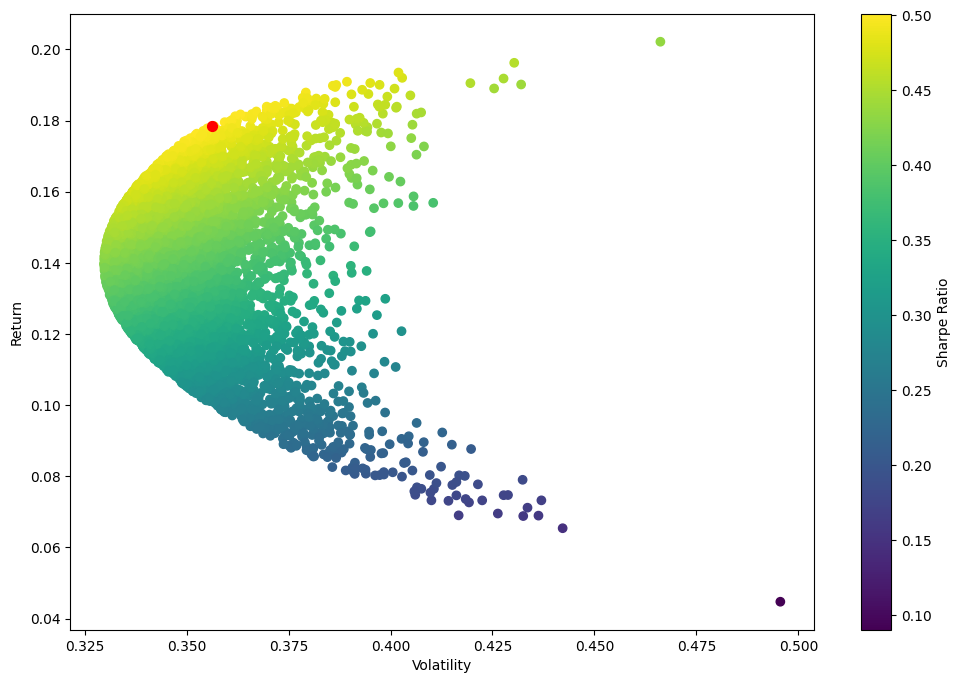

In [83]:
print(chosen_tickers)
plot_efficient_frontier(chosen_simulation)

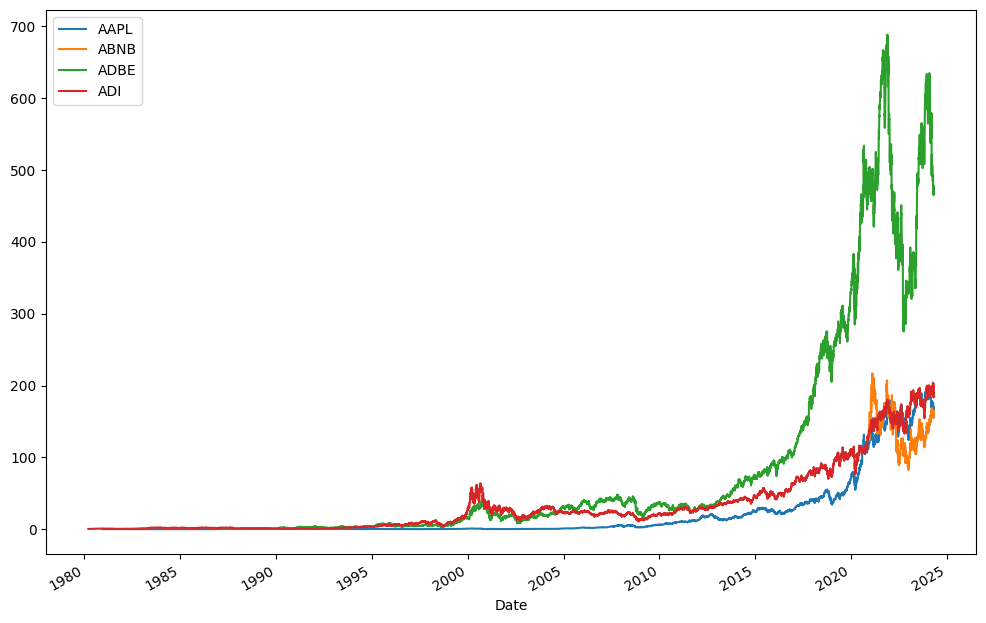

In [84]:
for column in chosen_stocks.columns:
    chosen_stocks[column].plot(figsize=(12, 8), legend=True)

In [85]:
# Set an equal initial guess for all asset weights
chosen_init_guess = [1 / len(chosen_log_ret.columns)] * len(chosen_log_ret.columns)


chosen_opt_results = minimize(
    fun=neg_sharpe,                        # Objective function to minimize
    x0=chosen_init_guess,                  # Initial guess for the weights
    args=(chosen_log_ret,),                # Extra arguments passed to the objective function
    method='SLSQP',                        # Optimization method
    bounds=chosen_bounds,                  # Bounds for each variable
    constraints=cons                       # Constraints, ensuring weights sum to 1
)


In [89]:
def minimize_volatility(weights, log_ret):
    return get_ret_vol_sr(weights, log_ret)[1]

def generate_frontiers():
    num_stocks = len(chosen_log_ret.columns)
    init_guess = np.array([1.0 / num_stocks] * num_stocks)
    bounds = tuple((0, 1) for _ in range(num_stocks))
    frontier_y = np.linspace(0, 0.8, 300)
    frontier_x = []

    for possible_return in frontier_y:
        cons = (
            {'type': 'eq', 'fun': check_sum},
            {'type': 'eq', 'fun': lambda w: get_ret_vol_sr(w, chosen_log_ret)[0] - possible_return}
        )
        result = minimize(minimize_volatility, init_guess, args=(chosen_log_ret,), method='SLSQP', bounds=bounds, constraints=cons)
        frontier_x.append(result['fun'])

    return {
        'x': frontier_x,
        'y': frontier_y
    }

def plot_portfolios(simulation, frontiers ):

    frontier_x = frontiers['x']
    frontier_y = frontiers['y']

    vol_arr = simulation['vol_arr']
    ret_arr = simulation['ret_arr']
    sharpe_arr = simulation['sharpe_arr']

    plt.figure(figsize=(12,8))
    scatter = plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
    plt.colorbar(scatter, label='Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    
    # Plot the efficient frontier
    plt.plot(frontier_x, frontier_y, 'r--', linewidth=3)
    
    plt.show()
    


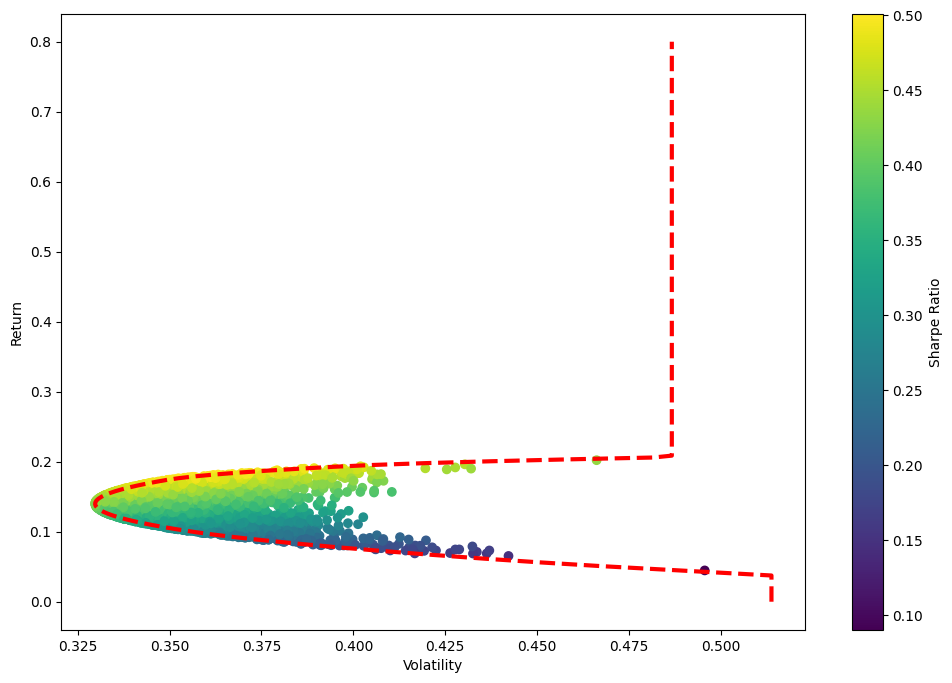

In [90]:
plot_portfolios(chosen_simulation, generate_frontiers())